In [1]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm.notebook import tqdm

import scipy.signal as signal
from myFilter import Filter as Filter
import os
plt.style.use('seaborn-whitegrid')

def calFFT(signal, window = 2048 , shift = False , inDB = False, half = True, normf=True, fs=None):
    
    from scipy.fftpack import fft, fftshift
    mag = np.abs(fft(signal, window) / (len(signal)/2.0))
    freq = np.linspace(0, 1, len(mag))

    if shift:
        mag = np.abs(fftshift(mag / abs(mag).max() ) )
        freq = np.linspace(-0.5, 0.5, len(mag))
        
    
    if inDB:
        mag = 20 * np.log10( mag )

    if normf == False:
        if fs == None:
            raise ValueError("Give me 'fs'")
        freq = np.linspace(0, fs, len(mag) )

    if half:
        mag = mag[:len(mag)//2]
        freq = freq[:len(freq)//2]

    return mag, freq

def matInfo(mat):
    print(mat.keys())
    for key in mat.keys():
        print(f"mat['{key}'] - {mat[key]}")

samplingRate = 1000 #hz

In [2]:
# step1: Devide the signal into the following bands
# For some reason, using (0.3,7) causes unwanted result
delta_theta = (2,7)
alpha = (8, 13)
low_beta = (14,20)
high_beta = (21,30)
low_gamma = (31,48)
# I think the 49 - 51 is left due to electrical interference
middle_gamma = (52,60)
high_gamma = (61,100)

bands_freq = {
    0 : delta_theta,
    1 : alpha,
    2 : low_beta,
    3 : high_beta,
    4 : low_gamma,
    5 : middle_gamma,
    6 : high_gamma
}

bands_name = {
    0 : '0_delta_theta',
    1 : '1_alpha',
    2 : '2_low_beta',
    3 : '3_high_beta',
    4 : '4_low_gamma',
    5 : '5_middle_gamma',
    6 : '6_high_gamma'
}
folder_name = f"EEG"

path = "dataset/20120904S11_EEGECoG_Chibi_Oosugi-Naoya+Nagasaka-Yasuo+Hasegawa+Naomi_ECoG128-EEG16_mat"
states = ["rest","recovery","deep-anesthetic","low-anesthetic"]
filt_highpass = Filter()
filt_highpass.setFilterType(Filter.TYPE_BUTTERWORTH)
filt_highpass.setFS(samplingRate)
highpassFreq = 0.1 #Hz
filt_highpass.setLowCut(highpassFreq)
filt_highpass.loadFilter(order=4)

filt_band = Filter()
filt_band.setFilterType(Filter.TYPE_BUTTERWORTH)
filt_band.setFS(samplingRate)

if(os.path.exists('EEG') == False):
    os.mkdir('EEG')

for state in states:
    eeg_mat = scipy.io.loadmat(f'{path}/EEG_{state}.mat')
    eeg = eeg_mat['EEG']
    file_name = f"EEG_{state}.mat"
    data = dict()
    for ch in range(16):
        data[f"{ch}"] = eeg[ch]
        eeg_highpass = filt_highpass.applyFilter(eeg[ch])
        data[f"{ch}_highpass"] = eeg_highpass
        for bn in [0,1,2,3,4,5,6]:
            temp_highpass = eeg_highpass
            filt_band.setBandPass(bands_freq[bn])
            filt_band.loadFilter(order=4)
            temp_filter = filt_band.applyFilter(temp_highpass)
            data[f"{ch}_{bands_name[bn]}"] = temp_filter
    scipy.io.savemat(f"{folder_name}/{file_name}", data)

for state in tqdm(states):
    ECoG_mat = scipy.io.loadmat(f'{path}/ECoG_{state}.mat')
    ECoG = ECoG_mat['ECoG']
    file_name = f"ECoG_{state}.mat"
    data = dict()
    for ch in tqdm(range(128)):
        data[f"{ch}"] = ECoG[ch]
        ECoG_highpass = filt_highpass.applyFilter(ECoG[ch])
        data[f"{ch}_highpass"] = ECoG_highpass
        for bn in [0,1,2,3,4,5,6]:
            temp_highpass = ECoG_highpass
            filt_band.setBandPass(bands_freq[bn])
            filt_band.loadFilter(order=4)
            temp_filter = filt_band.applyFilter(temp_highpass)
            data[f"{ch}_{bands_name[bn]}"] = temp_filter
    scipy.io.savemat(f"{folder_name}/{file_name}", data)



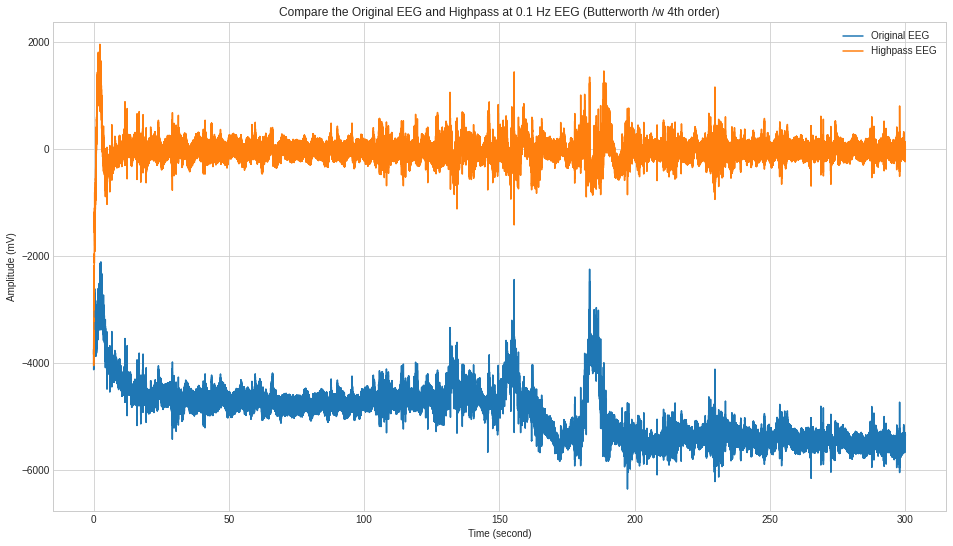

In [3]:
eeg_rest = scipy.io.loadmat('EEG/EEG_rest.mat')
fig, ax = plt.subplots(1, figsize=(16,9))
second = 300
t = np.linspace(0,second,second * samplingRate)

ax.plot(t, eeg_rest['0'][0], label="Original EEG")
ax.plot(t, eeg_rest['0_highpass'][0], label="Highpass EEG")
ax.set_xlabel(f"Time (second)")
ax.set_ylabel(f"Amplitude (mV)")
ax.set_title(f"Compare the Original EEG and Highpass at 0.1 Hz EEG (Butterworth /w 4th order)")
ax.legend()

# for band_name in bands_name.values():
#     ax[1].plot(t[4000:7000], eeg_rest[f'0_{band_name}'][0][4000:7000], label=f"{band_name}", lw=1, alpha=0.6)
# ax[1].set_xlabel(f"Time (second)")
# ax[1].set_ylabel(f"Amplitude (mV)")
# ax[1].set_title(f"Ploting each band from the 4 - 7 second")
# ax[1].legend()

plt.show()

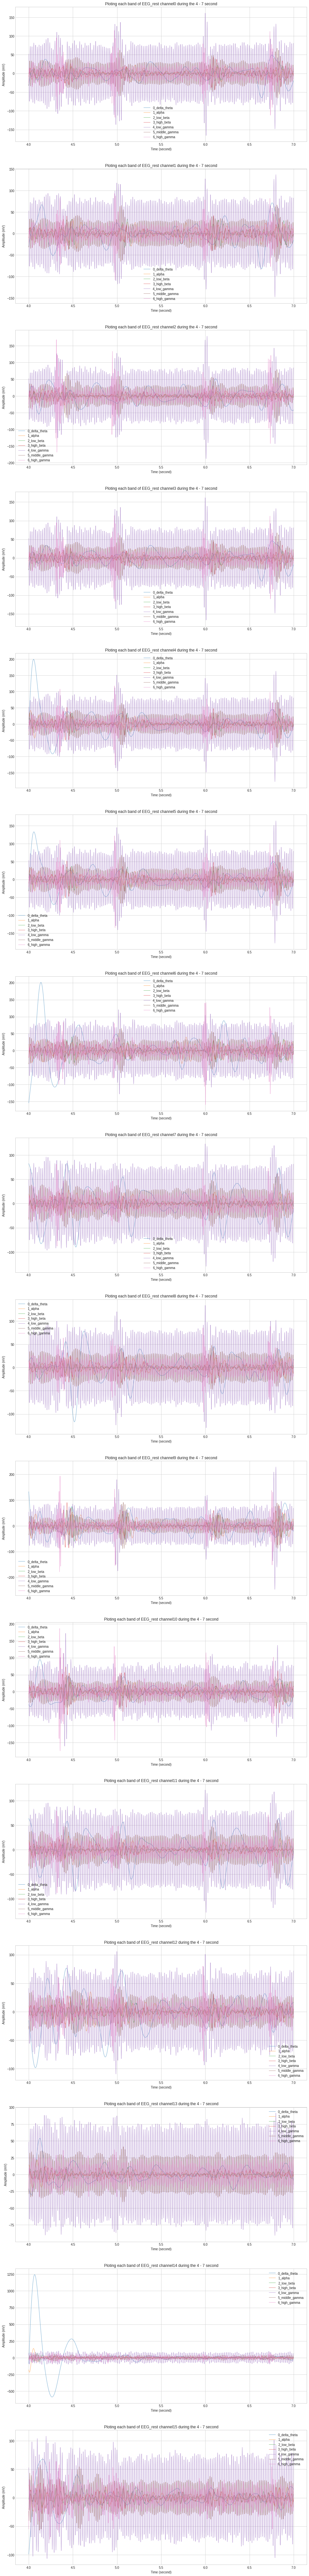

In [4]:
eeg_rest = scipy.io.loadmat('EEG/EEG_rest.mat')
fig, ax = plt.subplots(16, figsize=(16,9*16))
second = 300
t = np.linspace(0,second,second * samplingRate)

for i in range(16):
    for band_name in bands_name.values():
        ax[i].plot(t[4000:7000], eeg_rest[f'{i}_{band_name}'][0][4000:7000], label=f"{band_name}", lw=1, alpha=0.6)
        # ax[i].plot(t, eeg_rest[f'{i}_{band_name}'][0], label=f"{band_name}", lw=1, alpha=0.6)
    ax[i].set_xlabel(f"Time (second)")
    ax[i].set_ylabel(f"Amplitude (mV)")
    ax[i].set_title(f"Ploting each band of EEG_rest channel{i} during the 4 - 7 second")
    ax[i].legend()

plt.show()

In [ ]:
eeg_recovery = scipy.io.loadmat('EEG/EEG_recovery.mat')
fig, ax = plt.subplots(16, figsize=(16,9*16))
second = 300
t = np.linspace(0,second,second * samplingRate)

for i in range(16):
    for band_name in bands_name.values():
        ax[i].plot(t[4000:7000], eeg_recovery[f'{i}_{band_name}'][0][4000:7000], label=f"{band_name}", lw=1, alpha=0.6)
        # ax[i].plot(t, eeg_recovery[f'{i}_{band_name}'][0], label=f"{band_name}", lw=1, alpha=0.6)
    ax[i].set_xlabel(f"Time (second)")
    ax[i].set_ylabel(f"Amplitude (mV)")
    ax[i].set_title(f"Ploting each band of EEG_recovery channel{i} during the 4 - 7 second")
    ax[i].legend()

plt.show()